<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Lstm_Predictive_maintenance_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression¶
How many  hours an in-service engine will last before it fails?

In [1]:



import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


##################################
# Data Ingestion
##################################


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
#df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
#df['Time'] = pd.to_datetime(df['Time']) 
#df['Time']=[str(i).split(":")[0] for i in df["Time"]]
#df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
#df=df.groupby("Time").mean()
#df.reset_index(inplace=True)
#df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
#df.head()


In [3]:
#df=pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
#df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
#df=df.iloc[:,1:]
#df

In [4]:

df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [6]:
data=df.copy()

In [7]:

ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]
ariza_index = []
for i in ariza_tarihleri:
  ariza_index.append(df[df["Time"]==i].index[0])

In [8]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
#df["Week"] = df['Time'].apply(lambda t: t.week)


In [9]:
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)

In [10]:
for col in df.columns[1:7]:
  for i in [1,24,7*24]:
      df['lag_'+str(i)+col] = df[col].shift(i)


In [11]:
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(24*7).mean()
  df[col+'expanding_std'] = df[col].expanding(24*7).std()
  df[col+'expanding_mean_5'] = df[col].expanding(5).mean()
  df[col+'expanding_std_5'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)


In [12]:
df.reset_index(drop=True,inplace=True)

In [13]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]

In [14]:
df["rul"]=[np.nan for i in df.index]

In [15]:
onceki_ariza = 0
for i in range(len(ariza_tarihleri)):
  ariza=ariza_tarihleri[i]
  if onceki_ariza!=0:
    onceki_ariza = ariza_tarihleri[i-1]
  else:
    onceki_ariza ="2020-01-10 04:00:00"
  rul=[i for i in range(len(df.loc[df[df["Time"]==onceki_ariza].index[0]:df[df["Time"]==ariza].index[0]-1,"rul"].tolist()))]
  rul.reverse()
  df.loc[df[df["Time"]==onceki_ariza].index[0]:df[df["Time"]==ariza].index[0]-1,"rul"]= rul

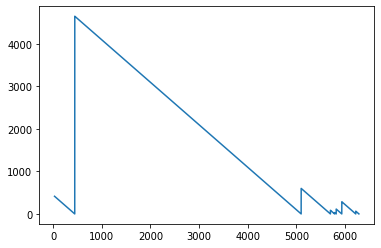

In [16]:
df["rul"].plot()

In [17]:
df.isna().sum()

Time                        0
vibx                        0
vibz                        0
temp                        0
zacc                        0
                         ... 
crestexpanding_mean         0
crestexpanding_std          0
crestexpanding_mean_5       0
crestexpanding_std_5        0
rul                      1863
Length: 91, dtype: int64

In [18]:
df

,Time,vibx,vibz,temp,zacc,zfreq,crest,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,...,lag_1vibz,lag_24vibz,lag_168vibz,lag_1temp,lag_24temp,lag_168temp,lag_1zacc,lag_24zacc,lag_168zacc,lag_1zfreq,lag_24zfreq,lag_168zfreq,lag_1crest,lag_24crest,lag_168crest,vibxexpanding_mean,vibxexpanding_std,vibxexpanding_mean_5,vibxexpanding_std_5,vibzexpanding_mean,vibzexpanding_std,vibzexpanding_mean_5,vibzexpanding_std_5,tempexpanding_mean,tempexpanding_std,tempexpanding_mean_5,tempexpanding_std_5,zaccexpanding_mean,zaccexpanding_std,zaccexpanding_mean_5,zaccexpanding_std_5,zfreqexpanding_mean,zfreqexpanding_std,zfreqexpanding_mean_5,zfreqexpanding_std_5,crestexpanding_mean,crestexpanding_std,crestexpanding_mean_5,crestexpanding_std_5,rul
0,2020-01-09 00:00:00,1.046063,0.834577,27.947439,0.223731,0.069944,3.415674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.907104,1.029025,0.144321,27.735658,28.809610,15.637208,0.263097,0.254351,0.041157,0.068594,0.069944,0.010000,3.995614,3.792513,4.111596,0.916849,0.323211,0.916849,0.323211,0.815337,0.288956,0.815337,0.288956,27.145674,4.955434,27.145674,4.955434,0.230588,0.081522,0.230588,0.081522,0.057733,0.020932,0.057733,0.020932,4.122783,0.432427,4.122783,0.432427,NaN
1,2020-01-09 01:00:00,1.040000,0.830000,27.950000,0.220000,0.070000,3.360000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.834577,0.841036,0.145520,27.947439,29.639916,15.373346,0.223731,0.217694,0.041440,0.069944,0.055415,0.010000,3.415674,4.114529,4.160439,0.917574,0.322392,0.917574,0.322392,0.815424,0.288102,0.815424,0.288102,27.150405,4.941136,27.150405,4.941136,0.230526,0.081285,0.230526,0.081285,0.057805,0.020891,0.057805,0.020891,4.118296,0.435096,4.118296,0.435096,NaN
2,2020-01-09 02:00:00,1.040000,0.830000,27.950000,0.220000,0.070000,3.360000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.830000,1.002815,0.146585,27.950000,28.317113,15.122024,0.220000,0.252369,0.041997,0.070000,0.064783,0.010000,3.360000,3.893997,4.212914,0.918290,0.321578,0.918290,0.321578,0.815509,0.287256,0.815509,0.287256,27.155081,4.926961,27.155081,4.926961,0.230464,0.081049,0.230464,0.081049,0.057877,0.020851,0.057877,0.020851,4.113862,0.437673,4.113862,0.437673,NaN
3,2020-01-09 03:00:00,1.040000,0.830000,27.950000,0.586704,0.070000,8.880379,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.830000,0.976084,0.143598,27.950000,28.411281,14.902892,0.220000,0.243994,0.043065,0.070000,0.066117,0.010000,3.360000,3.753816,4.331691,0.918997,0.320771,0.918997,0.320771,0.815593,0.286417,0.815593,0.286417,27.159703,4.912908,27.159703,4.912908,0.232536,0.085255,0.232536,0.085255,0.057947,0.020810,0.057947,0.020810,4.141574,0.567916,4.141574,0.567916,NaN
4,2020-01-09 04:00:00,1.040000,0.830000,27.950000,0.960000,0.070000,14.500000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.830000,1.000017,0.144605,27.950000,28.516537,14.703281,0.586704,0.240423,0.047041,0.070000,0.067873,0.010000,8.880379,3.672155,4.693571,0.919697,0.319969,0.919697,0.319969,0.815676,0.285585,0.815676,0.285585,27.164271,4.898974,27.164271,4.898974,0.236741,0.101416,0.236741,0.101416,0.058017,0.020770,0.058017,0.020770,4.201449,0.969983,4.201449,0.969983,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8114,2021-01-22 02:00:00,1.696243,1.339870,38.021661,0.669262,0.134723,5.019967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.233695,1.207518,1.483688,38.271590

In [19]:
ariza_tarihleri

['2020-01-27 14:00:00',
 '2020-09-11 14:00:00',
 '2020-10-06 18:00:00',
 '2020-10-10 08:00:00',
 '2020-10-13 04:00:00',
 '2020-10-18 00:00:00',
 '2020-10-30 09:00:00',
 '2020-11-02 05:00:00']

In [20]:
train_df=df[(df["Time"]<="2020-10-18 00:00:00") & (df["Time"]>"2020-01-09 08:00:00")]
test_df = df[df["Time"]>"2020-10-18 00:00:00"]


In [21]:
# MinMax normalization (from 0 to 1)

cols_normalize = df.columns[1:-1]

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#Test


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [22]:
train_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,...,lag_1vibz,lag_24vibz,lag_168vibz,lag_1temp,lag_24temp,lag_168temp,lag_1zacc,lag_24zacc,lag_168zacc,lag_1zfreq,lag_24zfreq,lag_168zfreq,lag_1crest,lag_24crest,lag_168crest,vibxexpanding_mean,vibxexpanding_std,vibxexpanding_mean_5,vibxexpanding_std_5,vibzexpanding_mean,vibzexpanding_std,vibzexpanding_mean_5,vibzexpanding_std_5,tempexpanding_mean,tempexpanding_std,tempexpanding_mean_5,tempexpanding_std_5,zaccexpanding_mean,zaccexpanding_std,zaccexpanding_mean_5,zaccexpanding_std_5,zfreqexpanding_mean,zfreqexpanding_std,zfreqexpanding_mean_5,zfreqexpanding_std_5,crestexpanding_mean,crestexpanding_std,crestexpanding_mean_5,crestexpanding_std_5,rul
9,2020-01-09 09:00:00,0.068401,0.065729,0.392867,0.046715,0.015400,0.762463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065729,0.048181,0.002550,0.392867,0.434702,0.110692,0.046715,0.007179,0.001447,0.015400,0.008828,0.000349,0.762463,0.167475,0.239876,0.079272,0.050320,0.079272,0.050320,0.480962,0.061957,0.480962,0.061957,0.254195,0.192338,0.254195,0.192338,0.042908,0.000000,0.042908,0.000000,0.075780,0.012146,0.075780,0.012146,0.000000,0.000000,0.000000,0.000000,NaN
10,2020-01-09 10:00:00,0.068401,0.065729,0.392867,0.046715,0.015400,0.762463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065729,0.080819,0.002472,0.392867,0.381545,0.110192,0.046715,0.011182,0.001298,0.015400,0.015504,0.000349,0.762463,0.136001,0.225631,0.080106,0.049870,0.080106,0.049870,0.481099,0.061385,0.481099,0.061385,0.254581,0.190814,0.254581,0.190814,0.047745,0.003104,0.047745,0.003104,0.076270,0.012061,0.076270,0.012061,0.011932,0.041058,0.011932,0.041058,NaN
11,2020-01-09 11:00:00,0.068401,0.065729,0.392867,0.046715,0.015400,0.762463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065729,0.082102,0.002746,0.392867,0.380308,0.110022,0.046715,0.011454,0.001018,0.015400,0.015321,0.000349,0.762463,0.140524,0.202053,0.080930,0.049424,0.080930,0.049424,0.481236,0.060819,0.481236,0.060819,0.254963,0.189303,0.254963,0.189303,0.052528,0.005994,0.052528,0.005994,0.076754,0.011976,0.076754,0.011976,0.023730,0.078803,0.023730,0.078803,NaN
12,2020-01-09 12:00:00,0.068401,0.065729,0.392867,0.046715,0.015400,0.762463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065729,0.077309,0.054451,0.392867,0.387137,0.129414,0.046715,0.011344,0.009831,0.015400,0.014976,0.011846,0.762463,0.140470,0.221876,0.081745,0.048980,0.081745,0.048980,0.481370,0.060257,0.481370,0.060257,0.255340,0.187804,0.255340,0.187804,0.057258,0.008699,0.057258,0.008699,0.077234,0.011891,0.077234,0.011891,0.035399,0.113778,0.035399,0.113778,NaN
13,2020-01-09 13:00:00,0.068401,0.065729,0.392867,0.046715,0.015400,0.762463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065729,0.073894,0.122416,0.392867,0.392979,0.316166,0.046715,0.011179,0.016946,0.015400,0.014800,0.027544,0.762463,0.137833,0.180579,0.082552,0.048540,0.082552,0.048540,0.481504,0.059699,0.481504,0.059699,0.255713,0.186316,0.255713,0.186316,0.061936,0.011243,0.061936,0.011243,0.077708,0.011807,0.077708,0.011807,0.046939,0.146390,0.046939,0.146390,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [23]:
test_df

,Time,vibx,vibz,temp,zacc,zfreq,crest,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,...,lag_1vibz,lag_24vibz,lag_168vibz,lag_1temp,lag_24temp,lag_168temp,lag_1zacc,lag_24zacc,lag_168zacc,lag_1zfreq,lag_24zfreq,lag_168zfreq,lag_1crest,lag_24crest,lag_168crest,vibxexpanding_mean,vibxexpanding_std,vibxexpanding_mean_5,vibxexpanding_std_5,vibzexpanding_mean,vibzexpanding_std,vibzexpanding_mean_5,vibzexpanding_std_5,tempexpanding_mean,tempexpanding_std,tempexpanding_mean_5,tempexpanding_std_5,zaccexpanding_mean,zaccexpanding_std,zaccexpanding_mean_5,zaccexpanding_std_5,zfreqexpanding_mean,zfreqexpanding_std,zfreqexpanding_mean_5,zfreqexpanding_std_5,crestexpanding_mean,crestexpanding_std,crestexpanding_mean_5,crestexpanding_std_5,rul
0,2020-10-18 01:00:00,0.051903,0.049496,0.713961,0.012551,0.009629,0.164085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.422309,0.949439,0.664252,0.574848,0.806562,0.800924,0.112660,1.010217,0.788138,0.089462,1.020791,0.844191,0.274083,0.205410,0.334580,0.999827,0.999924,0.999827,0.999924,0.999869,0.999914,0.999869,0.999914,1.000122,0.986738,1.000122,0.986738,0.999848,0.999703,0.999848,0.999703,0.999835,0.999709,0.999835,0.999709,0.087054,0.007800,0.087054,0.007800,285.0
1,2020-10-18 02:00:00,0.078113,0.060381,0.666116,0.020539,0.015385,0.173858,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.049496,0.949439,0.644800,0.713961,0.806562,0.798864,0.012551,1.010217,0.785525,0.009629,1.020791,0.827560,0.164085,0.205410,0.345893,0.999728,0.999836,0.999728,0.999836,0.999771,0.999825,0.999771,0.999825,1.000208,0.986655,1.000208,0.986655,0.999729,0.999620,0.999729,0.999620,0.999698,0.999629,0.999698,0.999629,0.087040,0.007752,0.087040,0.007752,284.0
2,2020-10-18 03:00:00,0.002853,0.002565,0.631337,0.000344,0.000174,0.147461,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.060381,0.949439,0.596683,0.666116,0.806562,0.785681,0.020539,1.010217,0.715971,0.015385,1.020791,0.776710,0.173858,0.205410,0.401361,0.999417,0.999798,0.999417,0.999798,0.999494,0.999766,0.999494,0.999766,1.000270,0.986558,1.000270,0.986558,0.999528,0.999544,0.999528,0.999544,0.999487,0.999556,0.999487,0.999556,0.087010,0.007711,0.087010,0.007711,283.0
3,2020-10-18 04:00:00,0.079112,0.063026,0.591807,0.021520,0.015226,0.179342,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.002565,0.949439,0.698031,0.631337,0.806562,0.779996,0.000344,1.010217,0.809905,0.000174,1.020791,0.873753,0.147461,0.205410,0.332325,0.999321,0.999710,0.999321,0.999710,0.999405,0.999676,0.999405,0.999676,1.000303,0.986452,1.000303,0.986452,0.999413,0.999461,0.999413,0.999461,0.999349,0.999476,0.999349,0.999476,0.086999,0.007662,0.086999,0.007662,282.0
4,2020-10-18 05:00:00,0.066156,0.053237,0.585217,0.017832,0.012800,0.178536,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.063026,0.949439,0.442799,0.591807,0.806562,0.799926,0.021520,1.010217,0.557910,0.015226,1.020791,0.617720,0.179342,0.205410,0.269161,0.999189,0.999628,0.999189,0.999628,0.999285,0.999588,0.999285,0.999588,1.000331,0.986344,1.000331,0.986344,0.999283,0.999379,0.999283,0.999379,0.999199,0.999397,0.999199,0.999397,0.086988,0.007613,0.086988,0.007613,281.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [24]:
# pick  window size 
sequence_length = 24

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols=train_df.columns.difference(["rul","Time"])

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array.shape)


(5900, 24, 89)


In [25]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df, sequence_length, ['rul'])]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(5900, 1)


In [26]:
model_path = "/content/drive/MyDrive/model_predictive_maintanence/regression_model.h5"

In [27]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae',r2_keras]) #'rmsprop'

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=500, batch_size=12, validation_split=False, verbose=1)
model.save(model_path)
# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 100)           76000     
_________________________________________________________________
dropout (Dropout)            (None, 24, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 106,251
Trainable params: 106,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
492/492 [==============================] - 18s 29ms/step - loss: 5601643.8311 - mae: 1858.6736 - r2

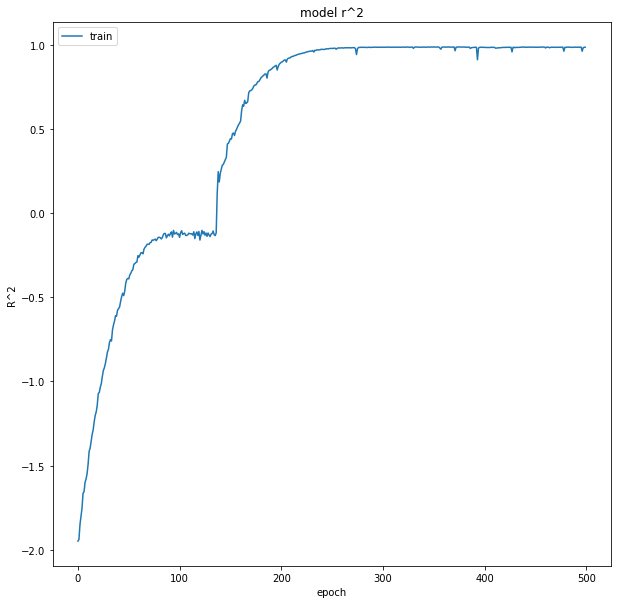

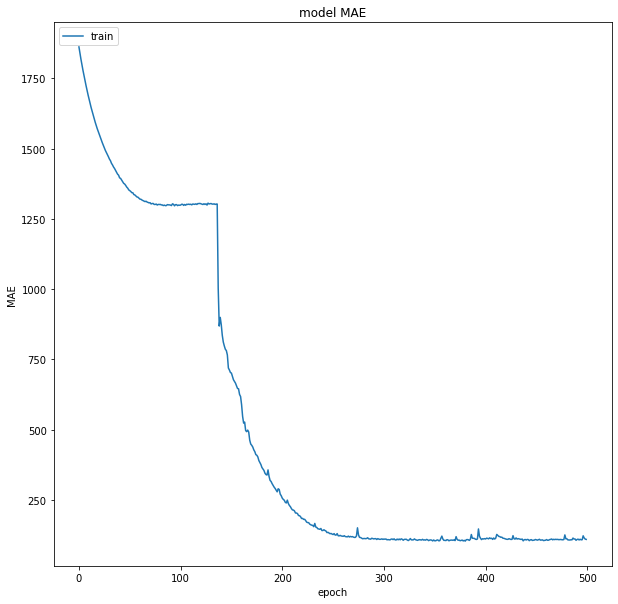

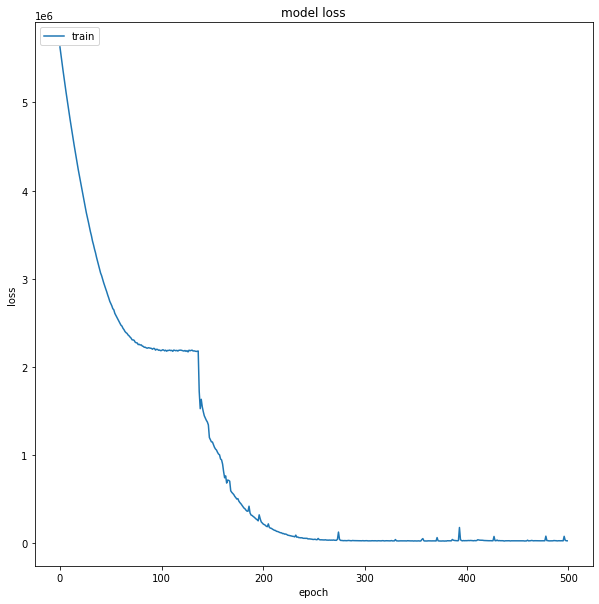

30/30 [==============================] - 2s 46ms/step


In [28]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
#plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for Mae
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
#scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=24)
#print('\nMAE: {}'.format(scores[1]))
#print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

In [29]:
# pick the feature columns 
test_df = pd.concat([train_df,test_df],axis=0)
sequence_cols=test_df.columns.difference(["rul","Time"])

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
seq_gen1 = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array1 = np.concatenate(list(seq_gen1)).astype(np.float32)    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
seq_array_test_last1=np.reshape(seq_array1, (len(seq_gen1),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape)
print(seq_array_test_last1.shape)
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['rul'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)
# generate labels
label_gen1 = [gen_labels(train_df, sequence_length, ['rul'])]
label_array_test_last1 = np.concatenate(label_gen1).astype(np.float32)
print(label_array_test_last1.shape)

(8086, 24, 89)
(5900, 24, 89)
(8086, 1)
(5900, 1)


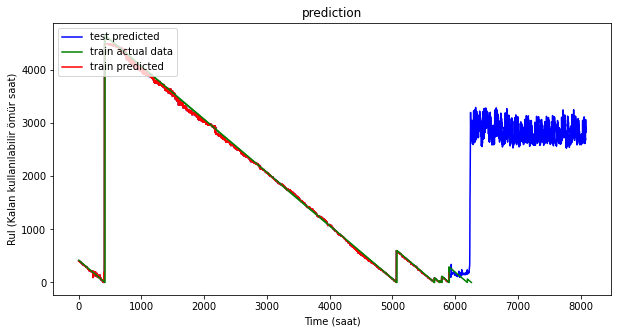

In [50]:
 

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    #scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    #print('\nMAE: {}'.format(scores_test[1]))
    #print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    y_pred_train = estimator.predict(seq_array_test_last1)
    y_true_train = label_array_test_last1

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_train, color="green")
    plt.plot(y_pred_train,color="red")
    plt.plot(df.loc[24:,"rul"].reset_index(drop=True),color= "green")
    plt.title('prediction')
    plt.ylabel('Rul (Kalan kullanılabilir ömür saat)')
    plt.xlabel('Time (saat)')
    plt.legend(['test predicted', 'train actual data',"train predicted"], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

In [32]:
np.min(y_pred_test)

0.41830444

In [33]:
np.max(y_pred_test)

4485.5933

Text(0.5, 0, 'Time (saat)')

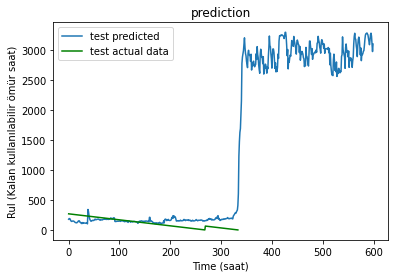

In [51]:
plt.plot(y_pred_test[5900:6500])
plt.plot(df.loc[5950:,"rul"].reset_index(drop=True),color= "green")
plt.legend(['test predicted', 'test actual data'], loc='upper left')
plt.title('prediction')
plt.ylabel('Rul (Kalan kullanılabilir ömür saat)')
plt.xlabel('Time (saat)')

In [38]:
np.min(y_pred_test[6000:6500])

103.50657

In [39]:
np.max(y_pred_test[6000:6500])

3293.878

In [41]:
3290/24/30

4.569444444444445

In [49]:
106/24

4.416666666666667